<a href="https://colab.research.google.com/github/AdarshShah/Mars-Tycho-Brahe-Kepler/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mars Orbit
Author : Adarsh Shah

Date : 18th Aug, 2021 

In [87]:
import numpy as np
from matplotlib import pyplot
import pandas as pd
from math import radians, cos, sin, tan, sqrt, fmod, atan, degrees
import datetime
from scipy import optimize as op

# Data Preparation

In [143]:
# Orbit Center in degrees
c = 0 
# Orbit radius
r = 8
# Equant Center
e1 = 1
e2 = 1
# Equant 0 in degrees
z = 0
# Mars angular velocity in degrees per day
s = 360/687

In [89]:
data = pd.read_csv("~/Desktop/01_data_mars_opposition_updated copy.csv")

lg = np.array(data['ZodiacIndex']*30 + data['Degree'] + data['Minute']/60 + data['Second']/3600)
elg = [ 0 ]
for i in range(1,12):
  d1 = datetime.datetime(data['Year'][i],data['Month'][i],data['Day'][i],data['Hour'][i],data['Minute.1'][i])
  d2 = datetime.datetime(data['Year'][i-1],data['Month'][i-1],data['Day'][i-1],data['Hour'][i-1],data['Minute.1'][i-1])
  ddelta = d1-d2
  elg += [elg[-1]+ddelta.days]
elg = np.array(elg)

elg.resize((12,1))
lg.resize(12,1)
oppositions=np.append(lg,elg,axis=1)

# Utils

In [90]:
# Equant Polar to co-ordinate
def p2c(e1,e2):
  x = e1*cos(radians(fmod(e2,360)))
  y = e1*sin(radians(fmod(e2,360)))
  return x,y

In [91]:
# Equant Co-ordinate to Polar
def c2p(x,y):
  e1 = sqrt(x**2+y**2)
  e2 = degrees(atan(y/x))
  return e1,e2

In [92]:
# Intersection of Latitude and orbit.
def intersect(e1,e2,m,c,r):
    f = lambda x : [(x[0]-cos(radians(c)))**2 + (x[1]-sin(radians(c)))**2 - r**2,tan(radians(m))*(e1-x[0])-(e2-x[1])]
    res = op.fsolve(func=f,x0=[e1+2*r*cos(radians(m)),e2+2*r*sin(radians(m))])
    return res

In [93]:
# Distance between two co-ordinates.
def distance(x,y):
  return sqrt((y[0]-x[0])**2+(y[1]-x[1])**2)

In [94]:
# Plot
def plot(c,r,e1,e2,z,s,oppositions):
  pyplot.scatter(cos(radians(c)),sin(radians(c)),c='r')
  pyplot.scatter(e1,e2,c='b')
  pyplot.scatter(0,0,c='g')
  
  for o in oppositions[:,0]:
    pyplot.arrow(0,0,1.5*r*cos(radians(o)),1.5*r*sin(radians(o)),ls='-')
    x,y = intersect(0,0,o,c,r)
    pyplot.scatter(x,y)

  for o in oppositions[:,1]:
    m = fmod(o*s+z,360)
    pyplot.arrow(e1,e2,1.5*r*cos(radians(m)),1.5*r*sin(radians(m)),ls=':')
    x,y = intersect(e1,e2,m,c,r)
    pyplot.scatter(x,y)

  x = np.radians(np.arange(0,360))
  pyplot.plot(cos(radians(c))+r*np.cos(x),sin(radians(c))+r*np.sin(x))
  pyplot.show()


In [97]:
def obj(X,oppositions):
  c,r,e1,e2,z,s=X
  e1,e2 = p2c(e1,e2+z)
  e,emax = MarsEquantModel(c,r,e1,e2,z,s,oppositions)
  return np.sum(e)

# 1. MarsEquantModel

In [128]:
def MarsEquantModel(c,r,e1,e2,z,s,oppositions):
  # Intersection of Heliolongitudes and orbit
  ol = list()
  #Intersection of Equantlongitudes and orbit
  el = list()

  for o in oppositions[:,0]:
    x,y = intersect(0,0,o,c,r)
    ol.append([x,y])

  for o in oppositions[:,1]:
    x,y = intersect(e1,e2,fmod(o*s+z,360),c,r)
    el.append([x,y])

  x = np.radians(np.arange(0,360))

  # Distances between sun, equant intersect and latitude intersect
  d1 = list()
  d2 = list()
  d3 = list()

  for x in ol:
    d1.append(distance(x,[0,0]))
  
  for x,y in zip(ol,el):
    d3.append(distance(x,y))

  # Errors
  d1 = np.array(d1)
  d3 = np.array(d3)
  errors = np.rad2deg(np.arctan(np.divide(d3,d1)))
  max_error = np.max(errors)
  return errors,max_error

#2. BestOrbitInnerParams


In [204]:
def bestOrbitInnerParams(r,s,oppositions):
  maxError = 2*360
  print("Computing: [",end='')
  for c in np.linspace(0,360,25):
    print("#",end='')
    for z in np.linspace(0,360,25):
      for e1 in np.linspace(1,2,20):
        x,y = p2c(e1,c)
        err,mx = MarsEquantModel(c,r,x,y,z,s,oppositions)
        if(mx < maxError):
          _c,_r,_z,_errors,maxError = c,r,z,err,mx
          _e1,_e2 = p2c(e1,c)
  print("]")
  #res = op.minimize(fun=obj,x0=[_c,r,_e1,_e2,_z,s],args=oppositions,bounds=[(0,360),(r,r),(-2,2),(-2,2),(0,360),(s,s)])
  #c,r,e1,e2,z,s = res.x
  c,r,e1,e2,z,s = _c,_r,_e1,_e2,_z,s
  errors,maxError = MarsEquantModel(c,r,e1,e2,z,s,oppositions)
  return c,e1,e2,z,errors,maxError

#3. BestS

In [236]:
def bestS(r,oppositions):
  maxError = 720
  sgood = 360/687
  print("Iter :")
  iter=1
  for s in np.linspace(-0.01,0.01,25):
    print(f'{iter:2}/50: ',end='')
    iter+=26
    _c,_e1,_e2,_z,_errors,_maxError = bestOrbitInnerParams(r,360/687+s,oppositions)
    if maxError > _maxError:
      c,e1,e2,z,errors,maxError=_c,_e1,_e2,_z,_errors,_maxError
      sgood = 360/687+s
  print("]")
  #res = op.minimize(fun=obj,x0=[_c,rgood,_e1,_e2,_z,sgood],args=oppositions,bounds=[(0,360),(rgood-1,rgood+1),(-1,1),(-1,1),(0,360),(s,s)])
  #c,r,e1,e2,z,s = res.x
  plot(c,r,e1,e2,z,sgood,oppositions)
  #errors,maxError = MarsEquantModel(c,r,e1,e2,z,s,oppositions)
  return sgood,errors,maxError

#4. BestR

In [235]:
def bestR(s,oppositions):
  maxError = 720
  rgood = 3
  print("Iter :")
  iter=1
  for r in np.linspace(7,11,25):
    print(f'{iter:2}/50: ',end='')
    iter+=1
    _c,_e1,_e2,_z,_errors,_maxError = bestOrbitInnerParams(r,s,oppositions)
    if maxError > _maxError:
      c,e1,e2,z,errors,maxError=_c,_e1,_e2,_z,_errors,_maxError
      rgood = r
  print("]")
  #res = op.minimize(fun=obj,x0=[_c,rgood,_e1,_e2,_z,sgood],args=oppositions,bounds=[(0,360),(rgood-1,rgood+1),(-1,1),(-1,1),(0,360),(s,s)])
  #c,r,e1,e2,z,s = res.x
  plot(c,rgood,e1,e2,z,s,oppositions)
  #errors,maxError = MarsEquantModel(c,r,e1,e2,z,s,oppositions)
  return rgood,errors,maxError

#5. BestMarsOrbitParams

In [237]:
def bestMarsOrbitParams(oppositions):
  r,er,emax = bestR(360/687,oppositions)  
  s,er,emax = bestS(r,oppositions)
  c,e1,e2,z,errors,maxError = bestOrbitInnerParams(r,s,oppositions)
  e1,e2 = c2p(e1,e2)
  e2 = fmod(e2-z+360,360)
  return r,s,c,e1,e2,z,errors,maxError

# Testing

In [ ]:
c,e1,e2,z,errors,maxError = bestOrbitInnerParams(4.5,s,oppositions)
print(maxError)
for x,y in enumerate(errors):
  print(f'{x:2} {y:.3f}')

In [ ]:
plot(c,4.5,e1,e2,z,s,oppositions)
print([c,4.5,e1,e2,z,s])

Iter :
 1/50: Computing: [#########################]
 2/50: Computing: [#########################]
 3/50: Computing: [#########################]
 4/50: Computing: [#########################]
 5/50: Computing: [#########################]
 6/50: Computing: [#########################]
 7/50: Computing: [#########################]
 8/50: Computing: [#########################]
 9/50: Computing: [#########################]
10/50: Computing: [#########################]
11/50: Computing: [#########################]
12/50: Computing: [#########################]
13/50: Computing: [#########################]
14/50: Computing: [#########################]
15/50: Computing: [#########################]
16/50: Computing: [#########################]
17/50: Computing: [#########################]
18/50: Computing: [#########################]
19/50: Computing: [#########################]
20/50: Computing: [#########################]
21/50: Computing: [#########################]
22/50: Computing: [########

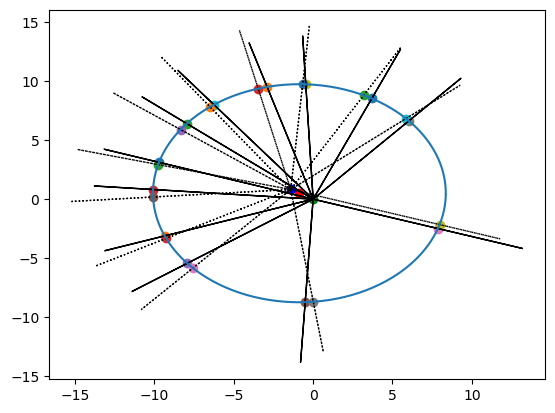

(9.224489795918368,
 array([3.55430025, 3.34667567, 3.58433378, 3.58680324, 3.20215572,
        3.34560587, 2.43728795, 1.70855802, 1.14247983, 1.73719487,
        1.12926192, 1.32613419]),
 3.5868032412817996)

In [223]:
bestR(360/687,oppositions)

Iter :
 1/50: Computing: [#########################]
 2/50: Computing: [#########################]
 3/50: Computing: [#########################]
 4/50: Computing: [#########################]
 5/50: Computing: [#########################]
 6/50: Computing: [#########################]
 7/50: Computing: [#########################]
 8/50: Computing: [#########################]
 9/50: Computing: [#########################]
10/50: Computing: [#########################]
11/50: Computing: [#########################]
12/50: Computing: [#########################]
13/50: Computing: [#########################]
14/50: Computing: [#########################]
15/50: Computing: [#########################]
16/50: Computing: [#########################]
17/50: Computing: [#########################]
18/50: Computing: [#########################]
19/50: Computing: [#########################]
20/50: Computing: [#########################]
21/50: Computing: [#########################]
22/50: Computing: [########

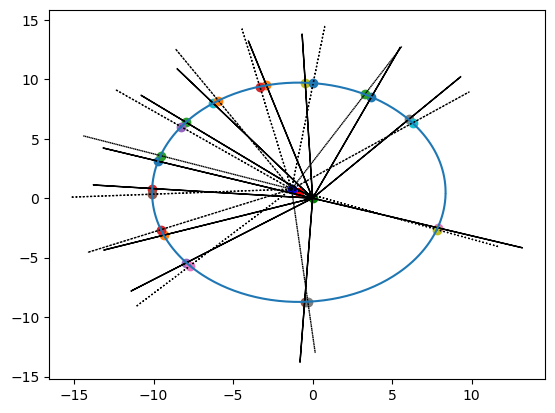

NameError: ignored

In [227]:
r = 9.224489795918368
bestS(r,oppositions)

Iter :
 1/50: Computing: [#########################]
 2/50: Computing: [#########################]
 3/50: Computing: [#########################]
 4/50: Computing: [#########################]
 5/50: Computing: [#########################]
 6/50: Computing: [#########################]
 7/50: Computing: [#########################]
 8/50: Computing: [#########################]
 9/50: Computing: [#########################]
10/50: Computing: [#########################]
11/50: Computing: [#########################]
12/50: Computing: [#########################]
13/50: Computing: [#########################]
14/50: Computing: [#########################]
15/50: Computing: [#########################]
16/50: Computing: [#########################]
17/50: Computing: [#########################]
18/50: Computing: [#########################]
19/50: Computing: [#########################]
20/50: Computing: [#########################]
21/50: Computing: [#########################]
22/50: Computing: [########

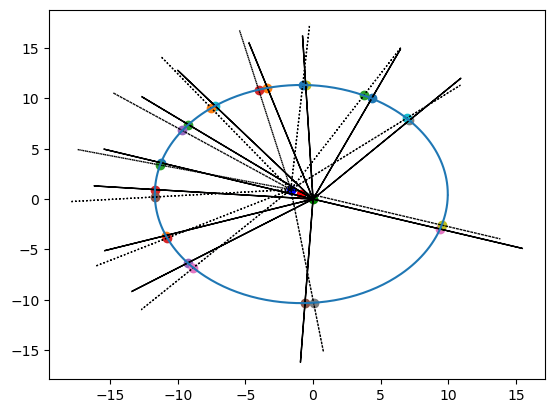

Iter :
 1/50: Computing: [#############

In [ ]:
bestMarsOrbitParams(oppositions)

In [111]:
def obj(X,oppositions):
  c,r,e1,e2,z,s=X
  #e1,e2 = p2c(e1,e2+z)
  e,emax = MarsEquantModel(c,r,e1,e2,z,s,oppositions)
  return emax
r=4